In [1]:
import os
import pandas as pd
import tensorflow as tf
import os
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam
import numpy as np
from sklearn.preprocessing import OneHotEncoder
from sklearn.utils.class_weight import compute_class_weight
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense, Dropout, Bidirectional, Conv1D, GlobalMaxPooling1D, Concatenate, AdditiveAttention
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import AdditiveAttention
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from utils import eval, eval_training, get_train_test_data, save_for_evaluation, process_train_test_data
import re
import numpy as np
import spacy
from gensim.models import Word2Vec
from transformers import BertTokenizer, TFBertModel


os.environ['TF_NUM_INTEROP_THREADS'] = '10'
os.environ['TF_NUM_INTRAOP_THREADS'] = '10'

# Configure TensorFlow session for multi-threading
tf.config.threading.set_inter_op_parallelism_threads(10)
tf.config.threading.set_intra_op_parallelism_threads(10)
# Ensure TensorFlow is using the Metal backend
gpu = len (tf.config.list_physical_devices ('GPU'))>0
print ("GPU is", "available" if gpu else "NOT AVAILABLE")

GPU is available


# Data preparation

label
other-minor                 9633
meniskus-urgent             9185
cruciate-ligament-urgent    2377
meniskus-minor              1657
cruciate-ligament-minor      354
Name: count, dtype: int64


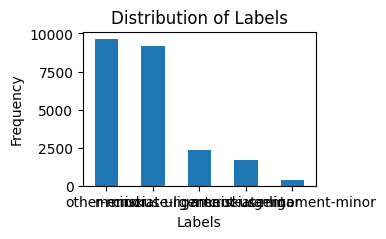

In [2]:
data_label = "data"
predict_label = "label"
balanced = False
labels = None
class_weights = False
sample_weights = False
df_train = pd.read_csv('../data/data_train.csv')
df_valid = pd.read_csv('../data/data_valid.csv')
df_test = pd.read_csv('../data/data_test.csv')

train_padded, valid_padded, test_padded, train_labels, valid_labels, test_labels, label_encoder, num_classes, max_length, word_index, class_weights, sample_weights = process_train_test_data(df_train, df_valid, df_test, data_label, predict_label, lables=labels, class_weights=class_weights, sample_weights=sample_weights)

# Model parameters

In [3]:

df_train = df_train.dropna(subset=['data'])
df_valid = df_valid.dropna(subset=['data'])
df_test = df_test.dropna(subset=['data'])

In [4]:
print(df_train["data2"].iloc[1])


Geht sehr gut nach LCA-Plastik. Score liegt bei alex. Mein Knie hat einen geringen Erguß und es gibt Schmerzen auf der medialen Seite des Kniegelenks.


In [5]:
model_name = "final2"

In [8]:
from utils import get_standard_parameters

optimizer, loss, metrics, early_stopping_callback, embedding_dim, lstm_units, epochs, batch_size = get_standard_parameters()

2024-08-11 10:04:03.564488: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M3 Max
2024-08-11 10:04:03.564547: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 64.00 GB
2024-08-11 10:04:03.564556: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 24.00 GB
2024-08-11 10:04:03.564586: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-08-11 10:04:03.564610: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [5]:
from tensorflow.keras.callbacks import Callback
class LossHistory(Callback):
    def on_train_begin(self, logs={}):
        self.losses = []

    def on_batch_end(self, batch, logs={}):
        self.losses.append(logs.get('val_loss'))

loss_history = LossHistory()

# Model definition and training

In [8]:
from tensorflow.keras.optimizers import Adam



In [9]:
from tensorflow.keras.layers import Conv1D, GlobalMaxPooling1D, GlobalAveragePooling1D, MaxPooling1D
from tensorflow.keras.layers import Attention, Flatten, BatchNormalization, Bidirectional, LSTM, Dropout, Dense
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding

# Define the input layer
input_text = Input(shape=(max_length,), dtype='int32', name='text_input')

# Embedding layer
embedding = Embedding(input_dim=len(word_index), output_dim=embedding_dim)(input_text)

# Two LSTM layers with L2 regularization

x = Conv1D(filters=512, kernel_size=50, activation='relu')(embedding) # was 25
x = MaxPooling1D(pool_size=25)(x)
#x = Dropout(0.2)(x)
x = Bidirectional(LSTM(units=1024, return_sequences=True))(x) # 512

# Applying Attention Mechanism
query, value = x, x
attention = Attention()([query, value])
x = Flatten()(attention)

x = Dense(units=128, activation='relu')(x)

# Output layer
output = Dense(num_classes, activation='softmax')(x)

# Define the model
model = Model(inputs=input_text, outputs=output)

# Compile the model
model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

In [10]:
history = model.fit(train_padded, train_labels, epochs=50, batch_size=96,
                    validation_data=(valid_padded, valid_labels), callbacks=[early_stopping_callback])

Epoch 1/50


2024-08-11 10:04:10.086275: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


242/242 ━━━━━━━━━━━━━━━━━━━━ 83s 336ms/step - accuracy: 0.3974 - auc: 0.7613 - f1_score: 0.1811 - loss: 1.3116 - val_accuracy: 0.4211 - val_auc: 0.8018 - val_f1_score: 0.1934 - val_loss: 1.1717
Epoch 2/50
242/242 ━━━━━━━━━━━━━━━━━━━━ 156s 647ms/step - accuracy: 0.4531 - auc: 0.8135 - f1_score: 0.2736 - loss: 1.1422 - val_accuracy: 0.4927 - val_auc: 0.8331 - val_f1_score: 0.2948 - val_loss: 1.1041
Epoch 3/50
242/242 ━━━━━━━━━━━━━━━━━━━━ 290s 1s/step - accuracy: 0.5673 - auc: 0.8731 - f1_score: 0.3693 - loss: 0.9706 - val_accuracy: 0.5656 - val_auc: 0.8615 - val_f1_score: 0.3568 - val_loss: 1.0426
Epoch 4/50
242/242 ━━━━━━━━━━━━━━━━━━━━ 200s 826ms/step - accuracy: 0.6959 - auc: 0.9298 - f1_score: 0.4973 - loss: 0.7388 - val_accuracy: 0.6416 - val_auc: 0.8888 - val_f1_score: 0.4843 - val_loss: 0.9720
Epoch 5/50
242/242 ━━━━━━━━━━━━━━━━━━━━ 203s 837ms/step - accuracy: 0.8116 - auc: 0.9686 - f1_score: 0.7141 - loss: 0.4962 - val_accuracy: 0.6789 - val_auc: 0.8984 - val_f1_score: 0.5756 - va

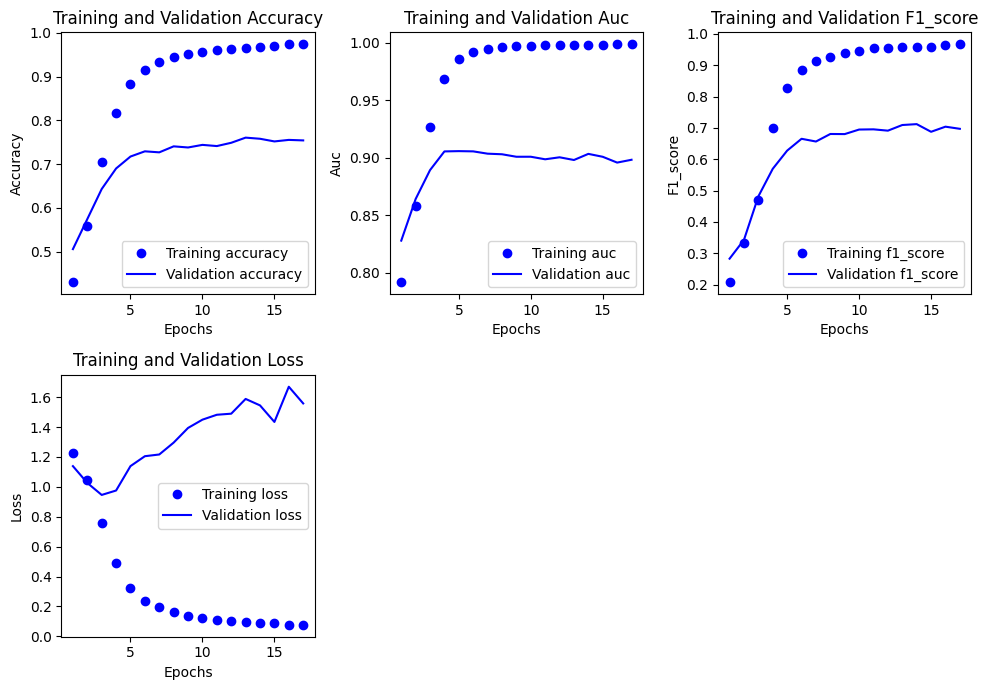

In [ ]:
eval_training(history, metrics)

242/242 ━━━━━━━━━━━━━━━━━━━━ 8s 31ms/step


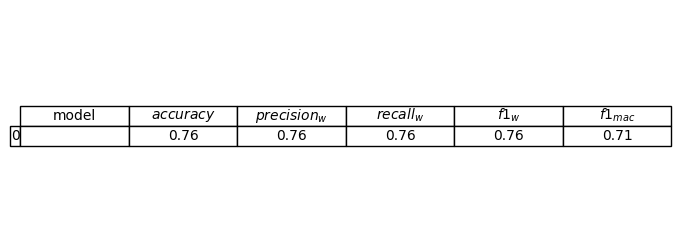

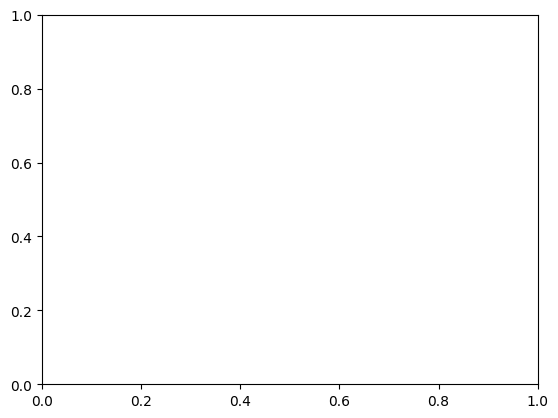

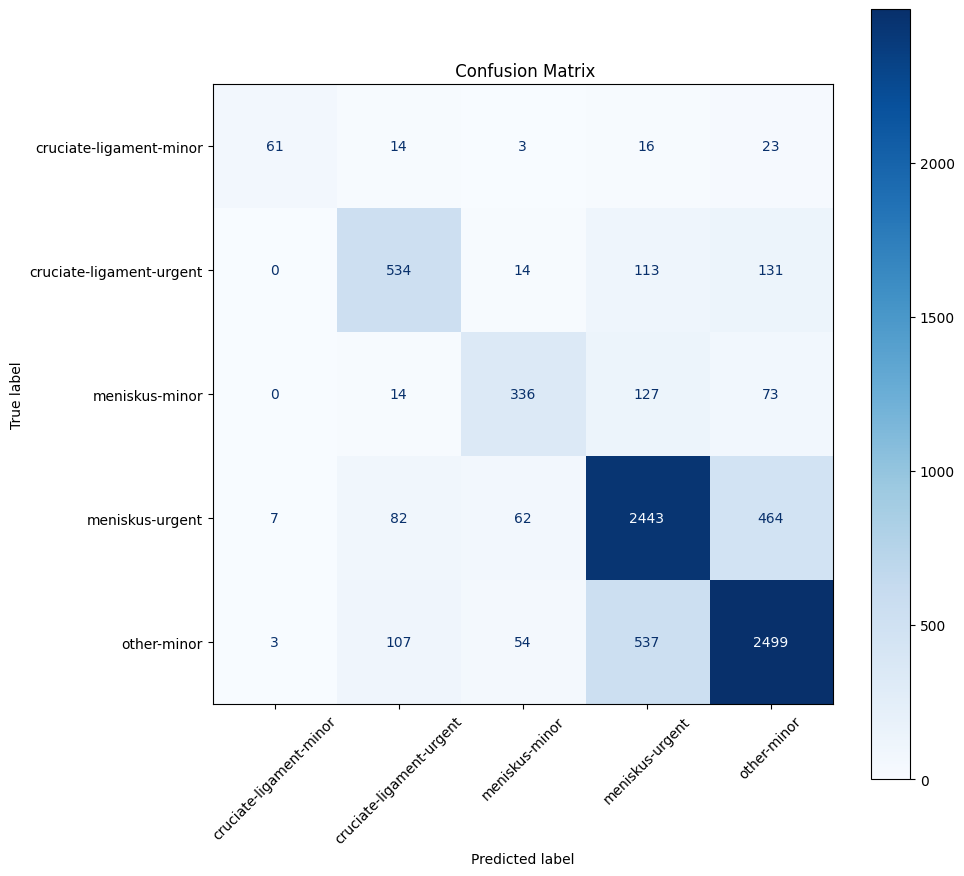

ValueError: Cannot embed the '../reports/lstm/.png' image format

In [11]:
eval(model, test_padded, test_labels, label_encoder)

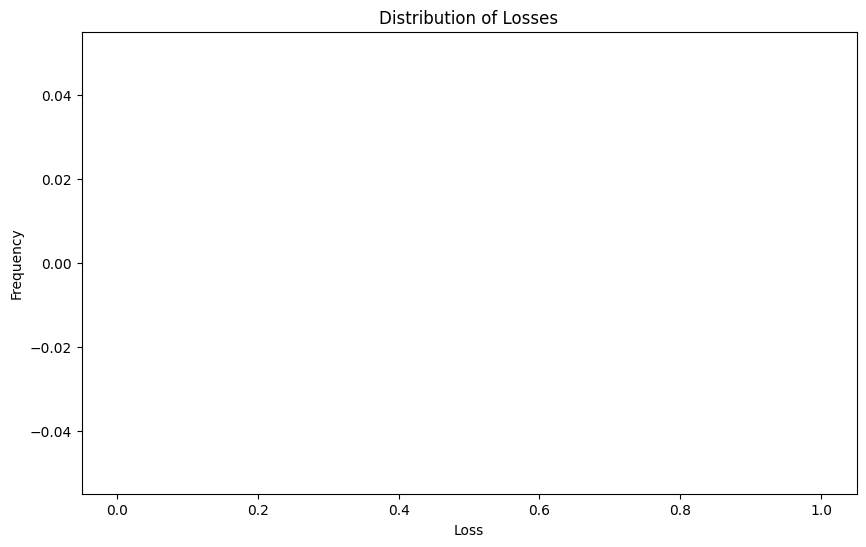

[None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, Non

In [ ]:
losses = list(filter(lambda item: item is not None, loss_history.losses))
plt.figure(figsize=(10, 6))
plt.hist(losses, bins=50, alpha=0.75, color='blue')
plt.title('Distribution of Losses')
plt.xlabel('Loss')
plt.ylabel('Frequency')
plt.show()
print(loss_history.losses)

246/246 ━━━━━━━━━━━━━━━━━━━━ 15s 61ms/step
Indices of most problematic samples: [6303 6355 5831 1893 6559 2240 7715 4645 5312 4432]
Loss values of most problematic samples: [16.118095 16.118095 16.118095 16.118095 16.118095 16.118095 16.118095
 16.118095 16.118095 16.118095]


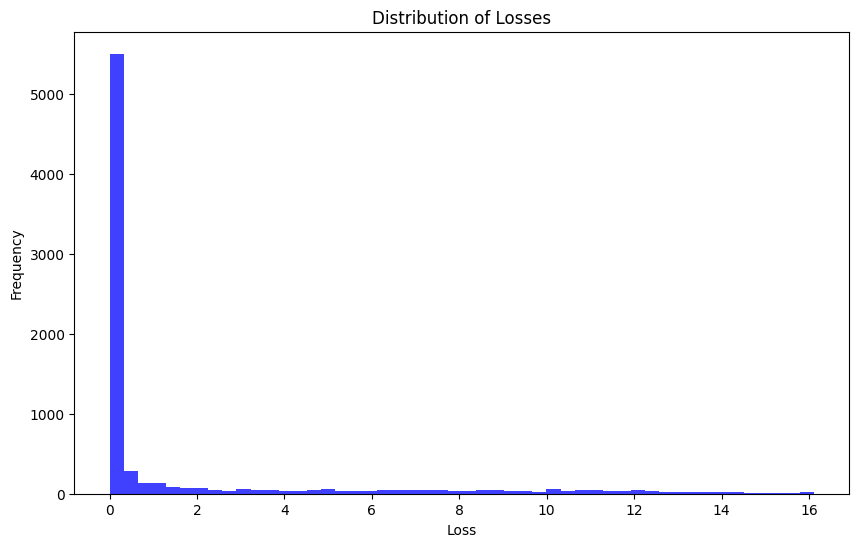

In [ ]:
# Function to calculate loss per sample
def calculate_loss_per_sample(model, x, y):
    predictions = model.predict(x)
    loss_fn = tf.keras.losses.CategoricalCrossentropy(reduction=tf.keras.losses.Reduction.NONE)
    losses = loss_fn(y, predictions)
    return losses.numpy()

# Calculate losses for each sample
sample_losses = calculate_loss_per_sample(model, valid_padded, valid_labels)

# Find indices of the highest losses
num_problematic = 10  # Number of problematic samples to identify
problematic_indices = np.argsort(sample_losses)[-num_problematic:]

# Print the most problematic samples
print("Indices of most problematic samples:", problematic_indices)
print("Loss values of most problematic samples:", sample_losses[problematic_indices])
plt.figure(figsize=(10, 6))
plt.hist(sample_losses, bins=50, alpha=0.75, color='blue')
plt.title('Distribution of Losses')
plt.xlabel('Loss')
plt.ylabel('Frequency')
plt.show()


In [ ]:
# Optional: Analyze the problematic samples
for index in problematic_indices:
    print(f"Sample {index} - Features: {df_train.iloc[index]['data']}, Label: {label_encoder.inverse_transform([np.argmax(train_labels[index])])}, Loss: {sample_losses[index]}")

Sample 6303 - Features: 26.0 Jahre alt weiblich Pat stellt sich heute mit den kompletten Unterlagen vor.. Mein rechtes Knie hat keine Schwellung, keine Rötung und auch keine Überstreckung oder Streckdefizite. Die Beugung des Knies ist gut möglich., Label: ['meniskus-urgent'], Loss: 16.11809539794922
Sample 6355 - Features: 20.0 Jahre alt männlich Vor 5 Monaten beim Fußball mit li. Fuß in Kunstrasen hängengeblieben und dabei das linke Knie verdreht; Knallgeräusch gehhört. Seither zwischendurch Schwellung und wegknickereignisse. Pat. stellt sich mit MRT Bildern vor. Subj. Instabilitätsgefühl ca. 5 x givingway Ereignisse. Mein linkes Bein ist gerade, und mein Gangbild ist flüssig. Mein Knie ist nicht überstreckt, und es gibt kein Streckdefizit. Die Beugung des Knies ist gut möglich, und es gibt keine Schwellung. Es gibt Schmerzen an der inneren Seite des Knies, wenn man darauf drückt. Es gibt keinen Schmerz an der Kniescheibenspitze oder an der Kante der Kniescheibe., Label: ['other-minor

In [ ]:
df_train.iloc[6513]

Unnamed: 0.3                                                    6568
Unnamed: 0.2                                                    6568
Unnamed: 0.1                                                    6568
Unnamed: 0                                                      3172
patientid                                                    27596.0
sex                                                             male
age                                                             32.0
ANA                Seit mehreren Monaten Gonalgie re.; Belastungs...
EXA                re. Knie: physiologsche Beinachsen; Muskuläres...
DIA_text            Z.n.arthroskopischer Chirurgie des Kniegelenkes.
DIA_code                                                    M23.3- Z
OP_text                                                          NaN
OP_code                                                          NaN
EXA_formatted      mässiger gelenkerguß, druckschmerz innereer se...
EXA_interpreted    Mein Knie hat e

In [ ]:
save_for_evaluation(model, history, model_name, test_padded, test_labels, label_encoder)

Model saved to ../models/lstm/final/final.h5
Data saved


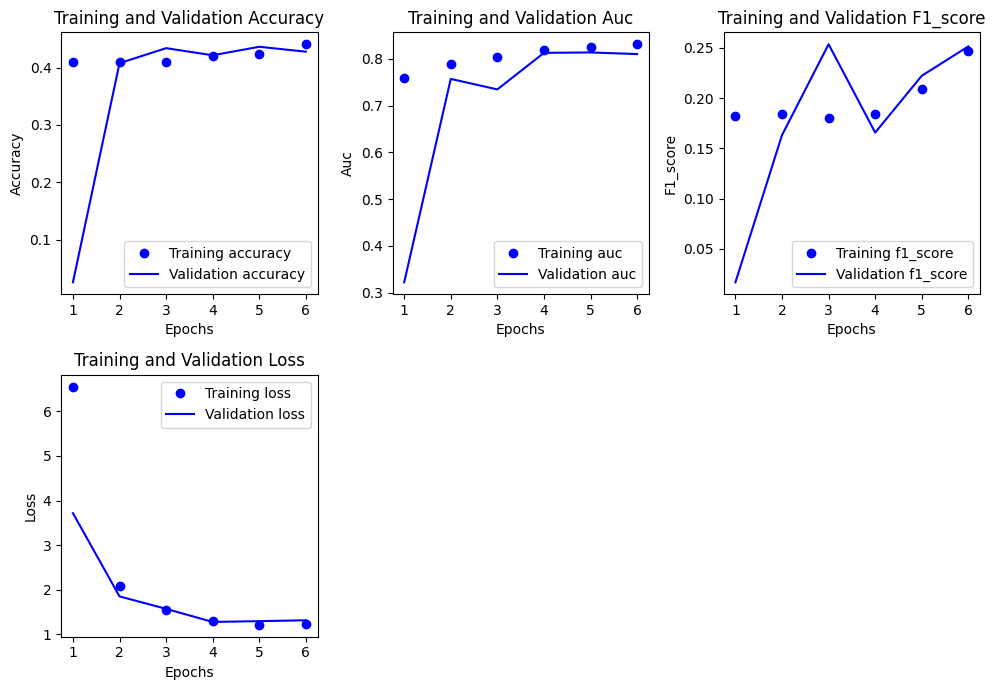

In [ ]:
eval_training(history, metrics)

246/246 ━━━━━━━━━━━━━━━━━━━━ 16s 64ms/step


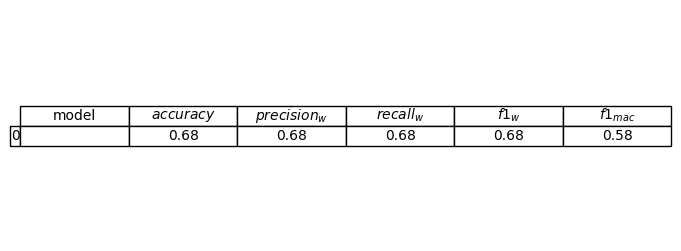

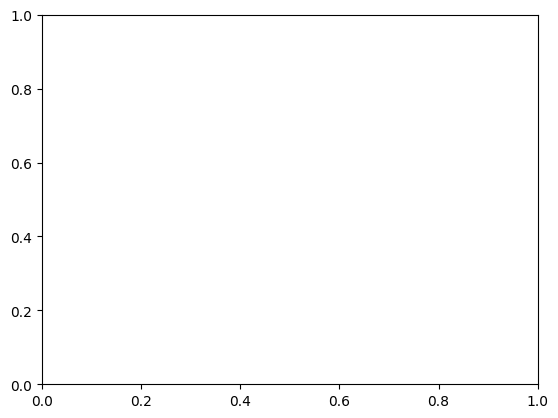

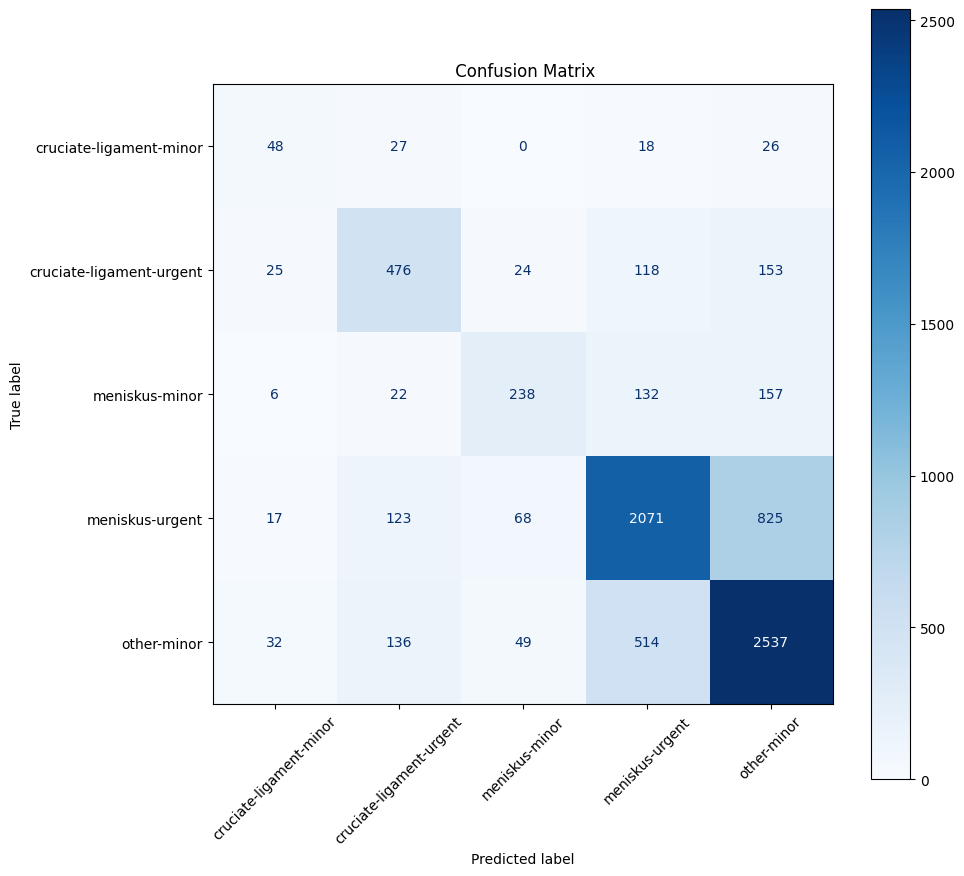

,model,$accuracy$,$precision_{w}$,$recall_{w}$,$f1_{w}$,$f1_{mac}$
0,,0.68,0.68,0.68,0.68,0.58


In [ ]:
eval(model, test_padded, test_labels, label_encoder)